### Task 2

(d) NN. Consider a neural network with the following hyperparameters: the initial weights
uniformly drawn in range [0,0.1] with learning rate 0.01.

    ● Train a single hidden layer neural network using the hyperparameters on the training dataset, except for the number of hidden units (x) which should vary among 5, 20, and 40. Run the optimization for 100 epochs each time. Namely, the input layer consists of n features x = [x1, ..., xn]^T , the hidden layer has x nodes z = [z1, ..., zx]^T , and the output layer is a probability distribution y = [y1, y2]^T over two classes.

    ● Plot the average training cross-entropy loss as shown below on the y-axis versus the number of hidden units on the x-axis. Explain the effect of numbers of hidden units.

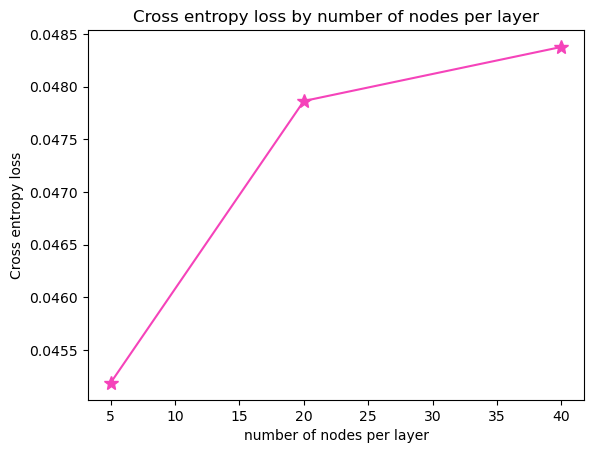

In [58]:
from sklearn.neural_network import MLPClassifier
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import numpy as np

def main():
    data = make_df("../../train.csv")
    y = data["Category"]
    test_data = make_df("../../test.csv")
    vector, vector_test = vectorize(data, test_data)

    cels = []
    num_nods = [5, 20, 40]
    for num in num_nods:
        probs, clf = make_classifier(vector, y, vector_test, num)
        cels.append(np.mean(clf.loss_curve_))

    plt.plot(num_nods, cels, marker = "*", color = "#F543BA", markersize = 10)
    plt.xlabel("number of nodes per layer")
    plt.ylabel("Cross entropy loss")
    plt.title("Cross entropy loss by number of nodes per layer")
    plt.show()
    
def vectorize(data, test_data):
    vectorizer = CountVectorizer()
    vectorizer.fit(data["Text"])
    vector = vectorizer.transform(data["Text"])
    test_vector = vectorizer.transform(test_data["Text"])
    return vector, test_vector

def make_df(filename):
    return pd.read_csv(filename)

def make_classifier(vector, y, vector_test, num_nodes = 5):
    # creating the untrained model
    clf = MLPClassifier(activation = 'relu',
                        solver = 'sgd',
                        learning_rate_init = 0.01,
                        max_iter = 100,
                        hidden_layer_sizes = (num_nodes,))

    # initialise weights
    clf.partial_fit(vector, y, classes=np.unique(y))

    # manually set weights to [0, 0.1]
    for i in range(len(clf.coefs_)):
        clf.coefs_[i] = np.random.uniform(0, 0.1, size=clf.coefs_[i].shape)
    for i in range(len(clf.intercepts_)): 
        clf.intercepts_[i] = np.random.uniform(0, 0.1, size=clf.intercepts_[i].shape)

    # training
    clf.fit(vector, y)

    probs = clf.predict_proba(vector_test)

    return probs, clf

main()

### Task 3

(a) We explore how the size of the training data set affects the test and train accuracy. For each
value of m in [0.1, 0.3, 0.5, 0.7, 0.9], train your classifier on the first m portion of the training
examples (that is, use the data given by XTrain[0:mN] and yTrain[0:mN]). Please report two
plots: (i) training and (ii) testing accuracy for each such value of m with the x-axis referring to m
and the y-axis referring to the classification accuracy in 𝐹1 measure as shown below. In total,
there should be four curves for training accuracy and four curves for testing accuracy. Explain
the general trend of the two plots in terms of training and testing accuracy if any.

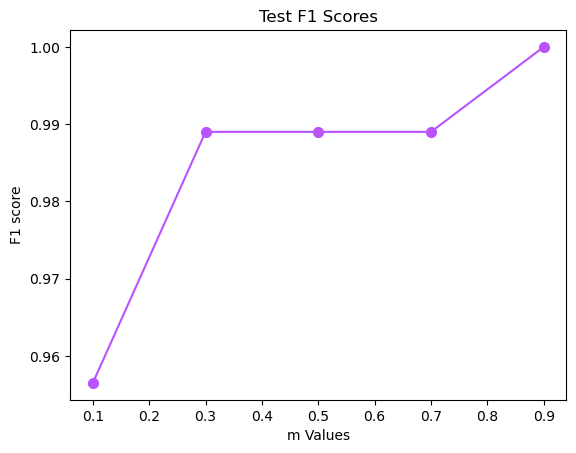

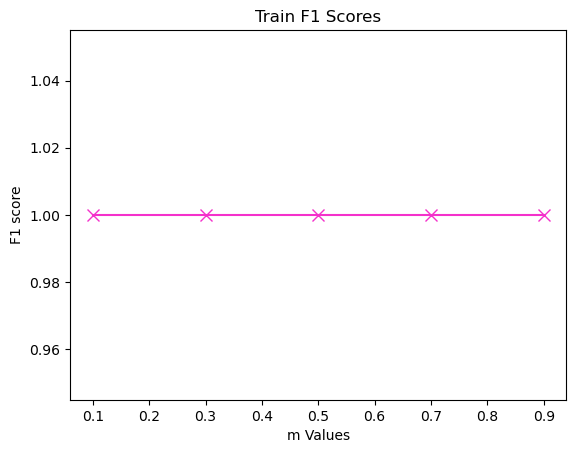

In [42]:
def main():
    data = make_df("../../train.csv")
    y = data["Category"]
    test_data = make_df("../../test.csv")
    y_test = test_data["Category"]       
    vector, vector_test = vectorize(data, test_data)

    test_f1s = []
    train_f1s = []
    ms = [0.1, 0.3, 0.5, 0.7, 0.9]
    for m in ms:
        train_f1, test_f1 = train_on_m(y, vector, vector_test, m, y_test)
        test_f1s.append(test_f1)
        train_f1s.append(train_f1)

    plt.plot(ms, test_f1s, marker = "o", color = "#BA52FF", markersize = 7)
    plt.title("Test F1 Scores")
    plt.xlabel("m Values")
    plt.ylabel("F1 score")
    plt.show()

    plt.plot(ms, train_f1s, marker = "x", color = "#F431CB", markersize = 8)
    plt.title("Train F1 Scores")
    plt.xlabel("m Values")
    plt.ylabel("F1 score")
    plt.show()
    
def train_on_m(train_y, vector, vector_test, m, y_test):
    sub_vector = vector[0:round(vector.shape[0]*m)]
    
    probs, clf = make_classifier(sub_vector, train_y[0:round(len(train_y)*m)], vector_test)

    preds_test = clf.predict(vector_test)

    preds_train = clf.predict(vector)

    train_f1 = calc_f1(preds_train, train_y)
    test_f1 = calc_f1(preds_test, y_test)

    return train_f1, test_f1

def calc_f1(preds, actual):
    tp = 0
    fp = 0
    fn = 0
    tn = 0

# Consider tech to be the positive class
    for i in range(len(preds)):
        if preds[i] == "tech" and actual[i] == "tech":
            tp += 1
        elif preds[i] == "tech" and actual[i] == "entertainment":
            fp += 1
        elif preds[i] == "entertainment" and actual[i] == "entertainment":
            tn += 1
        else:
            fn += 1

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2*((precision*recall) / (precision+recall))

    return f1

main()

**F1 Score Trends**

Training: The F1 score consistently stays at 1.0, indicating that on the training set, the model has perfect accuracy.
Testing: The F1 score is high regardless of the subset of the dataset that is used. Generally speaking, as we increase the proportion of the training set being used for training, the testing F1 score increases too.

(b) Let’s use 5-fold cross-validation to assess model performance. Investigate the impact of key
hyperparameters of your choices for each classifier using a testing dataset. E.g., for SVM, the
classification accuracy may be significantly affected by the kernels and hyperparameter
combination. List hyperparameters for each classifier and demonstrate how these
hyperparameters impact on the testing accuracy.

In [59]:
from sklearn.neural_network import MLPClassifier
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings("ignore")

def vectorize(data, test_data):
    vectorizer = CountVectorizer()
    vectorizer.fit(data["Text"])
    vector = vectorizer.transform(data["Text"])
    test_vector = vectorizer.transform(test_data["Text"])

    return vector, test_vector

def make_df(filename):
    return pd.read_csv(filename)

def main():
    data = make_df("../../train.csv")
    y = data["Category"]
    test_data = make_df("../../test.csv")
    y_test = test_data["Category"]       
    vector, vector_test = vectorize(data, test_data)
    probs, model = make_classifier(vector, y, vector_test)

    cross_validate(model, vector, y, vector_test, y_test)

def make_classifier(vector, y, vector_test, num_nodes = 5):
    # creating the untrained model
    clf = MLPClassifier(activation = 'relu',
                        solver = 'sgd',
                        learning_rate_init = 0.01,
                        max_iter = 100,
                        hidden_layer_sizes = (num_nodes,))

    # initialise weights
    clf.partial_fit(vector, y, classes=np.unique(y))

    # manually set weights to [0, 0.1]
    for i in range(len(clf.coefs_)):
        clf.coefs_[i] = np.random.uniform(0, 0.1, size=clf.coefs_[i].shape)
    for i in range(len(clf.intercepts_)): 
        clf.intercepts_[i] = np.random.uniform(0, 0.1, size=clf.intercepts_[i].shape)

    # training
    clf.fit(vector, y)

    probs = clf.predict_proba(vector_test)
    return probs, clf

def cross_validate(clf, train_descriptions, train_y, test_descriptions, test_y):
    scores = cross_val_score(clf, train_descriptions, train_y, cv=5, scoring="f1_macro")
    print("Scores for normal classifier:", scores, "with average", str(sum(scores) / len(scores)))

    # calculating learning rate accuracy scores
    learning_rates = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 0.75, 1, 2, 5]
    for learning_rate in learning_rates:
        # retrain clf
        clf = MLPClassifier(activation = 'relu', solver = 'sgd', learning_rate_init = learning_rate,
                        max_iter = 100, hidden_layer_sizes = (5,)).fit(train_descriptions, train_y)
        get_scores(clf, test_descriptions, test_y, "learning rate", learning_rate)

    # calculating epoch count accuracy scores
    max_iter_values = [5, 50, 100, 200, 500, 1000, 5000]
    for max_iter_val in max_iter_values:
        # retrain clf
        clf = MLPClassifier(activation = 'relu', solver = 'sgd', learning_rate_init = 0.01,
                        max_iter = max_iter_val, hidden_layer_sizes = (5,)).fit(train_descriptions, train_y)
        get_scores(clf, test_descriptions, test_y, "max iterations", max_iter_val)

    # calculating activation function accuracy scores
    activation_functions = ["relu", "identity", "logistic", "tanh"]
    for function in activation_functions:
        # retrain clf
        clf = MLPClassifier(activation = function, solver = 'sgd', learning_rate_init = 0.01,
                        max_iter = 100, hidden_layer_sizes = (5,)).fit(train_descriptions, train_y)
        get_scores(clf, test_descriptions, test_y, "activation function", function)

    # calculating hidden layer count accuracy scores
    num_layers = [1, 2, 3, 4, 5, 10, 20, 40]
    for num in num_layers:
        # retrain clf
        sizes = (5,) * num
        clf = MLPClassifier(activation = 'relu', solver = 'sgd', learning_rate_init = 0.01,
                        max_iter = 100, hidden_layer_sizes = sizes).fit(train_descriptions, train_y)
        get_scores(clf, test_descriptions, test_y, "number of layers = ", num)

    # taking subset of the best epochs and learning rates, and finding best accuracy for this
    max_iter_values = [100, 200, 500, 1000, 5000]
    learning_rates = [0.001, 0.005, 0.01, 0.05, 0.1]
    for iter_val in max_iter_values:
        for learning_rate in learning_rates:
            sizes = (5,) * 2
        # retrain clf for each combo of learning rate and max iter
            clf = MLPClassifier(activation = 'relu', solver = 'sgd', learning_rate_init = learning_rate,
                            max_iter = iter_val, hidden_layer_sizes = 2).fit(train_descriptions, train_y)
            get_scores(clf, test_descriptions, test_y, f"Max iterations = {iter_val},", f"learning rate = {learning_rate}") # change this text


def get_scores(clf, test_descriptions, test_y, hyperparam, value):
        scores = cross_val_score(clf, test_descriptions, test_y, cv=5, scoring="f1_macro")
        avg = sum(scores) / len(scores)
        # UNCOMMENT THIS PRINT TO SEE CV SCORES AND AVERAGES
        print(f"Score for {hyperparam} {value}:", scores, "with average", str(avg))

main()

Scores for normal classifier: [0.98837052 0.9767316  0.97674419 0.98822878 0.97646733] with average 0.9813084833392651
Score for learning rate 0.001: [1.         0.7597254  0.95194508 0.85176471 0.89903846] with average 0.8924947295940028
Score for learning rate 0.005: [0.95206972 0.95058824 1.         0.95058824 1.        ] with average 0.970649237472767
Score for learning rate 0.01: [1.         0.95058824 1.         0.89903846 1.        ] with average 0.9699253393665159
Score for learning rate 0.05: [1.         0.95058824 0.89903846 0.78571429 1.        ] with average 0.9270681965093729
Score for learning rate 0.1: [1.         0.95058824 1.         0.84444444 1.        ] with average 0.9590065359477125
Score for learning rate 0.5: [0.95206972 1.         0.95194508 0.78571429 1.        ] with average 0.9379458165162836
Score for learning rate 0.75: [1.         0.95058824 0.95058824 0.78571429 1.        ] with average 0.9373781512605042
Score for learning rate 1: [1.         0.95194508

Effects of different hyperparameters on the F1 score on the test data:
_Note that all other variables were constant wrt their initial settings from 2d) when constructed._
**Learning Rate** - This is adjusted by changing the learning_rate parameter of the MLPClassifier. We used values of 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 0.75, 1, 2, and 5 as test learning rates. For very small learning rates eg 0.001, the accuracy on the test set was fairly low, sitting at about 90% across muliple reruns. Slight increases in learning rate to 0.01 and 0.05 showed increased performance on the unseen test set to about 96%, with further increases of learning rate at and beyond ~0.5 again decreasing the test accuracy to as low as 69%.

Generally, for very small learning rates, the amount of time required for convergence is much higher. It could be that with the number of epochs used in the default case (100), a learning rate of 0.001 was too low for convergence to be reached as each iteration takes a very small step, and thus the model is not fully developed at the point execution is terminated. Conversely, for larger learning rates (start to see the decrease in accuracy at 0.1, but particularly those above ~0.5), we see a further decrease in accuracy. This could be due to the jumping behaviour that is often seen for large learning rates, where relative minima are completely overshot, and we never encounter convergence. Therefore, it appears that for this model, learning rates beyond about 0.5 are too large.
Therefore, for this model, it appears the best learning rate to use is somewhere between 0.005 and 0.05, depending on whether we have more epochs than the baseline classifier (thus a smaller learning rate) or less (thus need a slightly larger learning rate).

**Number of Epochs** - this is adjusted by changing the value of max_iter passed into the MLPClassifier. The values we tried were 5, 50, 100, 200, 500, 1000, and 5000.
For low epoch numbers (5 and 50), we recieved convergence warnings when running our models, saying that the number of epochs was too low for MLPClassifier to have converged. Additionally, for the lower 5 epoch run, the accuracy was quite clearly lower (~77%) compared to higher epoch counts. This suggests that for these low epoch counts, we are not reaching an optimal classifier before execution is terminated.

For all runs of 100 epochs or higher, the accuracy seems fairly consistent (~96-97%). This suggests that with the baseline settings from 2d), 100 epochs is sufficient to have a well trained model. As the number of epochs increases, so does computation expense, so that is also an important consideration to make to ensure that the model will terminate in good time. It is also worth noting that the default value for this in MLPClassifier is 200 - which is twice as large as our default.

For this model, any epoch count greater than 100 appears to be sufficient - this should be increased higher depending on the other hyperparameters we set.

**Activation Function** - Scikit Learn has an activation function parameter, which sets the activation function of the hidden layers. The options were "relu", "identity", "logistic" (ie sigmoid), and "tanh". The initial classifier we developed used the RelU function.
Running this multiple times, there was some variation, but all four models stayed relatively similar (93-95%). For this reason, it makes most sense to stick with Relu, which is relatively fast to train (so should stay high performing regardless of number of epochs). Note also that scikit learn by default uses sigmoid on the output layer.

**Number of Hidden Layers** - This was the final parameter we decided to adjust, since the number of nodes was already adjusted for 2d). We used values of 1, 2, 3, 4, 5, 10, 20, and 40.
The baseline classifier used 1 hidden layer, which is as low as possible, but had a decent accuracy score (93%). As the number of hidden layers increased to 4 and above, the accuracy massively decreased (~75% down to even 35% for more than 10 hidden layers). This could be due to overfitting on the training dataset, as the increased number of hidden layers makes the model more sensitive to noise and outliers in the training set. Also, as the number of hidden layers increases, the model is more susceptible to vanishing (very small) and exploding (very large) gradients during the back propogation algorithm, making weights disproportionate.

Since the number of hidden layers has nothing to do wth the number of epochs or learning rate, we have decided to set it to 2, to help further train the model slightly without risking overfitting.

**Combinations of Hyperparameters** - Finally, we decided to compare both the number of epochs and the learning rate simultaneously with one another, to find the optimal ratio. 

With 100 epochs, the best learning rate is ~92% which has a learning rate of 0.1. As we increase the number of epochs, the optimal learning rate more or less decreases. At 200 epochs, the best learning rate is 0.01, with accuracy of 96%. For 500, the best learning rate is also 0.01 at 96%, and for 1000 epochs, the best is 0.1, with 96% agin. At 5000 epochs the best is 0.1 with accuracy 93%. There is a tradeoff between the number of epochs and the learning rate - they are inversely proportional. For large epoch values >1000, the time taken to run the code was excessively long for minimal or no payoff in terms of optimal accuracy. Therefore, we have decided to use an epoch count of 500, with a learning rate of 0.01 as is the case with the baseline classifier, to get the best possible average accuracy over all cross validation folds of 96%.